Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Read the data
**Importing all the important libraries**

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
!unzip -u "/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment.zip" -d "/content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment"

Archive:  /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Ski

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


###Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

###Create a dataset
Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


###Visualize the data

Create a code to visualize one instance of all the nine classes present in the dataset

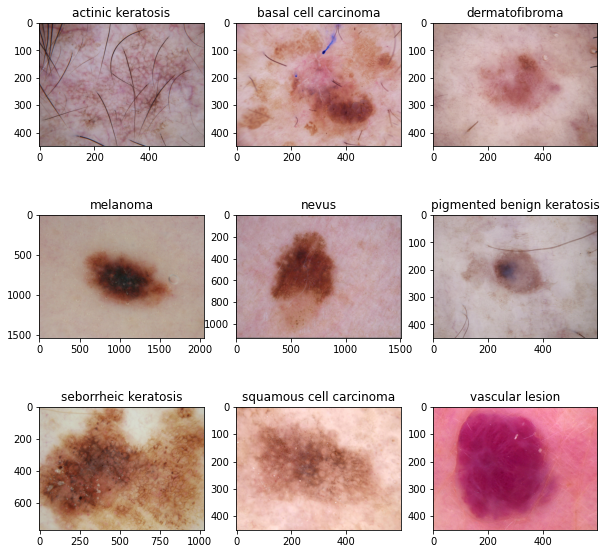

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Model#1

###Create the model

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [15]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Dropout(0.25))


model.add(Flatten())
#model.add(Dense(num_classes, activation = "softmax"))
model.add(Dense(num_classes))

Compile the model

Choose an appropirate optimiser and loss function for model training

In [16]:
from tensorflow.keras.optimizers import RMSprop

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 84s 1s/step - loss: 2.0525 - accuracy: 0.1825 - val_loss: 1.9950 - val_accuracy: 0.2371
Epoch 2/20
56/56 [==============================] - 64s 1s/step - loss: 1.8277 - accuracy: 0.3186 - val_loss: 1.6043 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 65s 1s/step - loss: 1.5302 - accuracy: 0.4531 - val_loss: 1.5659 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 64s 1s/step - loss: 1.4621 - accuracy: 0.4894 - val_loss: 1.4433 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 64s 1s/step - loss: 1.4316 - accuracy: 0.4989 - val_loss: 1.4080 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 64s 1s/step - loss: 1.2993 - accuracy: 0.5396 - val_loss: 1.4393 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 64s 1s/step - loss: 1.2285 - accuracy: 0.5658 - val_loss: 1.4586 - val_accuracy: 0.5190
Epoch 8/20
56/56 [==

Visualizing training results

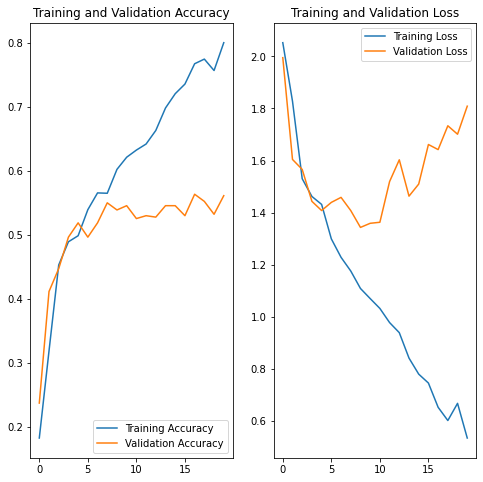

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###Findings on the first base model
**Initial findings:** The model is overfitting because overfitting is calculated w.r.t loss, and we can also see difference in loss functions in training & validation data around the 13-14th epoch

The accuracy is just around 76% for training data & around 52% for validation data because there are enough features to remember the pattern, and the neural network is very young (just 20 epochs), so the learning has just started.

In [21]:
data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

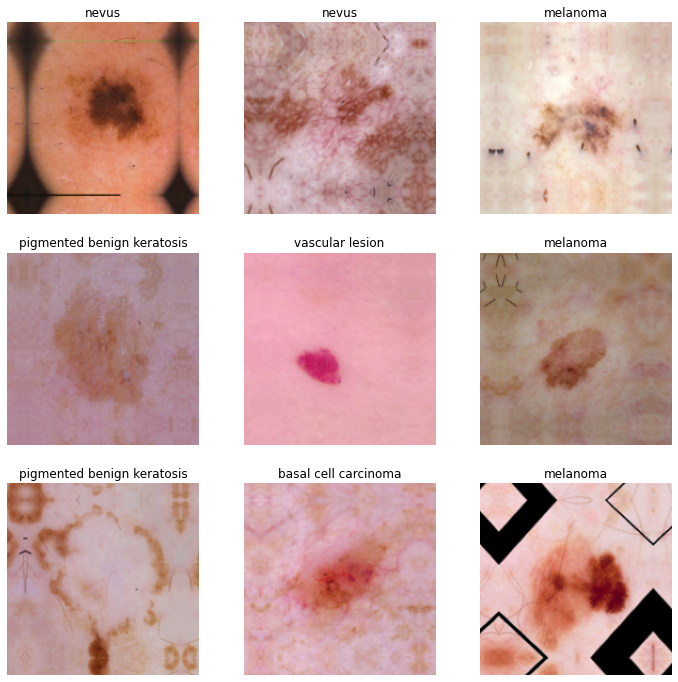

In [22]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##Model#2

###Create the second model, compile and train the model

Now, we will work on the second model to fix the problem of overfitting in the model. We will use the dropout layer 

In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Flatten())
#model.add(Dense(num_classes, activation = "softmax"))
model.add(Dense(num_classes))

### Compile the model

In [24]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

###Training the model

In [25]:
## Your code goes here, note: train your model for 100 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 76s 1s/step - loss: 1.9802 - accuracy: 0.2461 - val_loss: 1.8696 - val_accuracy: 0.3087
Epoch 2/20
56/56 [==============================] - 75s 1s/step - loss: 1.8700 - accuracy: 0.3069 - val_loss: 1.8331 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 75s 1s/step - loss: 1.7727 - accuracy: 0.3655 - val_loss: 1.7100 - val_accuracy: 0.4273
Epoch 4/20
56/56 [==============================] - 75s 1s/step - loss: 1.6476 - accuracy: 0.4141 - val_loss: 1.5045 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 75s 1s/step - loss: 1.5111 - accuracy: 0.4676 - val_loss: 1.6016 - val_accuracy: 0.4430
Epoch 6/20
56/56 [==============================] - 75s 1s/step - loss: 1.4789 - accuracy: 0.4883 - val_loss: 1.4375 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 75s 1s/step - loss: 1.4957 - accuracy: 0.4760 - val_loss: 1.5052 - val_accuracy: 0.5078
Epoch 8/20
56/56 [==

###Visualizing the results

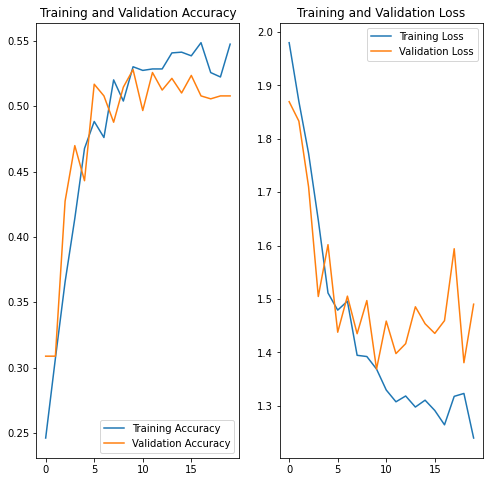

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#####Findings after the model#2 execution.

The model by using the dropout layer seems to be resolving the issue of overfitting & now there is not much difference in the accuracy of train & validation data. However, the accuracy seems to be low at 58%. 

#####Find the distribution of classes in the training dataset.

#####**Context**: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/CNN_As...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/CNN_As...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/CNN_As...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/CNN_As...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/CNN_As...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab Notebooks/CNN_As...,vascular lesion
2235,/content/gdrive/MyDrive/Colab Notebooks/CNN_As...,vascular lesion
2236,/content/gdrive/MyDrive/Colab Notebooks/CNN_As...,vascular lesion
2237,/content/gdrive/MyDrive/Colab Notebooks/CNN_As...,vascular lesion


<BarContainer object of 9 artists>

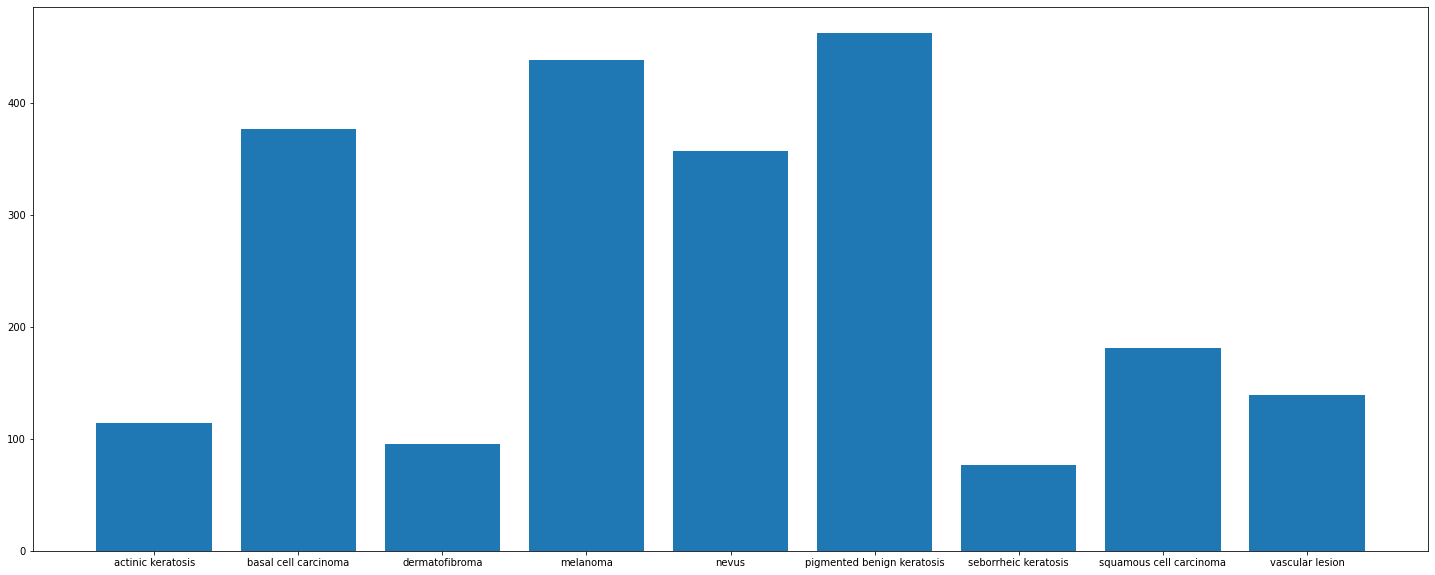

In [28]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

**Findings after visualizing the distribution of classes :** 
- There is a class imbalance observed 
- The number of images in the classes 'basal cell carcinoma, melanoma, nevus, pigmented benign keratosis'(more than 400) is very high in comparison to other classes
- Class 'seborrheic keratosis' contains the least number of images (below 100) .

Now, we will further refine the model to fix the issue of class imbalance by using augmentor

#####**Context**: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.

2. Define a number of operations to perform on this data set using your Pipeline object.

3. Execute these operations by calling the Pipeline’s sample() method.

In [30]:
path_to_training_dataset= "/content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF00D23D290>: 100%|██████████| 500/500 [00:27<00:00, 18.48 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF00D219F10>: 100%|██████████| 500/500 [00:27<00:00, 18.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF00D207D10>: 100%|██████████| 500/500 [00:28<00:00, 17.71 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FF00D219E50>: 100%|██████████| 500/500 [01:56<00:00,  4.28 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FF00D5C55D0>: 100%|██████████| 500/500 [01:46<00:00,  4.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF010D4BF90>: 100%|██████████| 500/500 [00:23<00:00, 21.19 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF00D54F250>: 100%|██████████| 500/500 [00:52<00:00,  9.50 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF010D41D50>: 100%|██████████| 500/500 [00:23<00:00, 21.63 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF010C3E990>: 100%|██████████| 500/500 [00:24<00:00, 20.77 Samples/s]


In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


####Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026729.jpg_1d427784-0639-446f-be09-2bc6e40e46a7.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_033ba5da-c55b-44c1-9edc-926279cfecbe.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_c99fd0f5-0cba-4d0a-a426-188587a5bb77.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_a1bb6392-03e7-4c60-bb36-72c8242304ac.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_Assign

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [36]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [38]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


 Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


##Model#3

Create the model

In [40]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
num_classes = 9
model = Sequential([ data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))
model.add(Dense(num_classes))

Compile your model

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)       

Train your model

In [42]:
epochs = 20
#epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 282s 2s/step - loss: 2.1368 - accuracy: 0.2094 - val_loss: 2.1993 - val_accuracy: 0.1678
Epoch 2/20
169/169 [==============================] - 275s 2s/step - loss: 2.0791 - accuracy: 0.2405 - val_loss: 2.2089 - val_accuracy: 0.1433
Epoch 3/20
169/169 [==============================] - 276s 2s/step - loss: 2.0318 - accuracy: 0.2502 - val_loss: 2.2663 - val_accuracy: 0.1366
Epoch 4/20
169/169 [==============================] - 275s 2s/step - loss: 2.0320 - accuracy: 0.2149 - val_loss: 2.0993 - val_accuracy: 0.1797
Epoch 5/20
169/169 [==============================] - 275s 2s/step - loss: 1.9790 - accuracy: 0.2428 - val_loss: 2.2000 - val_accuracy: 0.1752
Epoch 6/20
169/169 [==============================] - 274s 2s/step - loss: 1.9347 - accuracy: 0.2795 - val_loss: 1.9246 - val_accuracy: 0.2725
Epoch 7/20
169/169 [==============================] - 272s 2s/step - loss: 1.9157 - accuracy: 0.2914 - val_loss: 2.0742 - val_accuracy: 0.2413

Visualize the model result

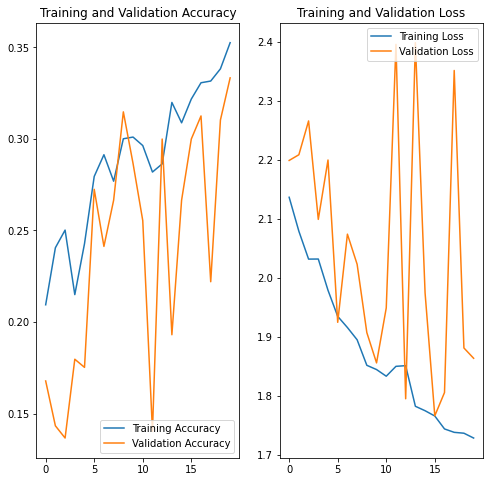

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observation : 
1. The model is doing well with respect to overfitting & class imbalance. 
2. Accuracy is slightly increased by using augmentor 
3. The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.
4. The Model can be further improved by tuning the hyperparameter
